In [1]:
from sympy import Matrix, symbols, sin, cos, trigsimp, init_printing, I, dsolve, \
    simplify, Eq, solve, expand, lambdify, diff, solveset, exp, factor, Sum, Derivative, \
    Function

In [2]:
init_printing()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

The object is to model a PWM signal through a simple resistor capacitor network (perhaps not the modern definition of network) of components

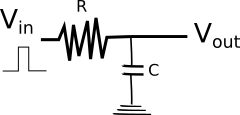

We assume there is no load on $V_{out}$ yet so we can consider it just a measurement point and then The differential equation for this follows:

In [5]:
c1, rho, rl, R,C,vin,vout, vc, t, t0 = symbols('C1 rho R_L R C V_{in} V_{out} v_c t t0')

First we present the specific ODE for this circuit.

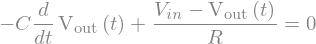

In [6]:
v = Function('V_{out}')
e1 = (vin - v(t))/R - C*Derivative(v(t)); Eq(e1,0)

Then we solve it for $V_{out}$ which is write it as function of the output voltage.

In [7]:
d1 = dsolve(e1); d1

Now we have to try and compute C1, the integration constant, from the output voltage at a given time $t_0$ which in our case we prefer to set to zero.


In [8]:
solve(d1, c1)[0].subs(t,0)

If the voltage is growing by charging the capacitor then we expect the graph to look like the following.

Text(0.5, 1.0, '$y=e^{-x}$')

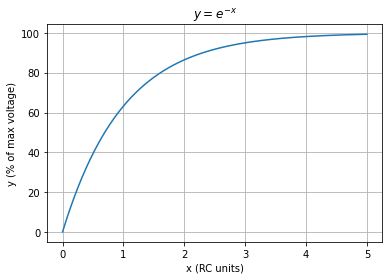

In [9]:
fig, ax = plt.subplots()
x = np.linspace(0,5,1000 )
y = (1-np.exp(-x))*100
ax.plot(x,y)
ax.grid()
ax.set_xlabel("x (RC units)")
ax.set_ylabel("y (% of max voltage)")
ax.set_title("$y=e^{-x}$")

If the capacitor is discharging through the resistor to zero volts then we expect the following.

Text(0.5, 1.0, '$y=e^{-x}$')

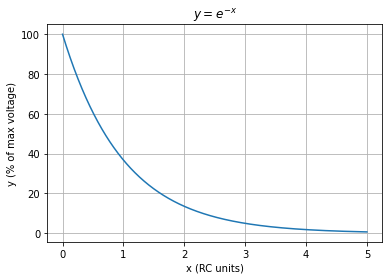

In [10]:
fig, ax = plt.subplots()
x = np.linspace(0,5,1000 )
y = (np.exp(-x))*100
ax.plot(x,y)
ax.grid()
ax.set_xlabel("x (RC units)")
ax.set_ylabel("y (% of max voltage)")
ax.set_title("$y=e^{-x}$")

We would expect a stable voltage is reached as the rise time and fall times become equal.

In [11]:
def f(t, c, vin):
    from numpy import exp
    return vin + c*exp(-t)

def pwmplot(period):
    fig, ax = plt.subplots()
    duty_cycles = [(0.2, 'r'), (0.5, "b"), (0.7, "g")]

    pulse_height = 1
    vcc = 5
    for duty, lblcolour in duty_cycles:
        c=-pulse_height
        for h in range(0,int(5/period)):
            x = np.linspace(0,duty*period, int(duty*500) )
            y = f(x, c, pulse_height)
            c = y[len(y)-1]
            x = x +h*period
            ax.plot(x,y*vcc, color=lblcolour)
            x = np.linspace(0,(1-duty)*period, int((1-duty)*500) )
            y = f(x, c, 0)
            c = y[len(y)-1]-pulse_height
            x = x+duty*period+h*period   
            line, = ax.plot(x,y*vcc, color=lblcolour)
            if h==0:
                line.set_label('{}%'.format(int(duty*100)))



    ax.set_title('PWM period = {:.2f} RC'.format(period))
    ax.set_ylabel('Volts')
    ax.set_xlabel('time (RC units)')
    ax.grid()
    ax.legend()


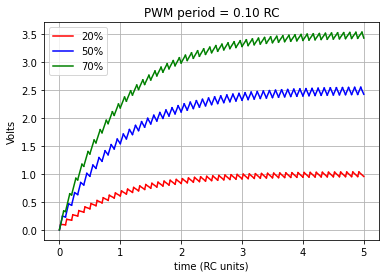

In [12]:
pwmplot(0.1)

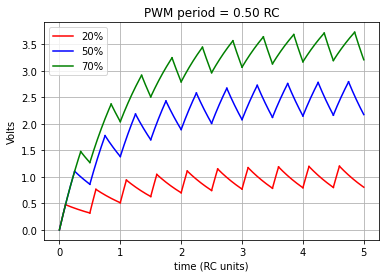

In [13]:
pwmplot(0.5)

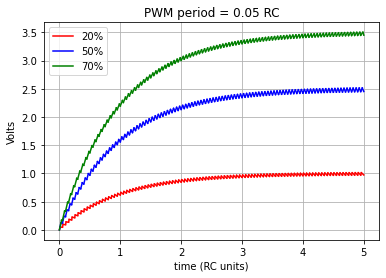

In [14]:
pwmplot(0.05)

Now we examine to see what happens if we add a load to the output of what we had before.  What I am expecting is that it will start to discharge the capacitor and affect the voltage accross the capacitor.

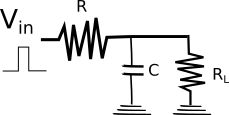

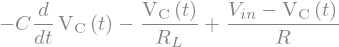

In [15]:
v = Function('V_{C}')
e2 = (vin - v(t))/R  - v(t)/rl - C*Derivative(v(t)); e2

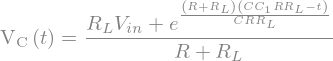

In [16]:
e3 = dsolve(e2); e3

The constant of integration looks like it is all mixed up in the exponent but given that $e^a e^b = e^{a+b}$ then I should be able to absorb most of that jumble of symbols into a constant at the front of the exponential.

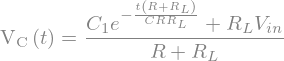

In [17]:
a1 = e3.args[1].args[0]  # R + RL
a2 = e3.args[1].args[1].args[0]  #RL + Vin
b1, b2, b3, b4, b5 = e3.args[1].args[1].args[1].args[0].args
a3 = b5.args[1]
e4 = Eq(v(t), a1*(a2 + c1 * exp(b1*b2*b3*b4*(-t)))); e4



In [18]:
fvc = lambdify([t, c1, R, C, rl, vin], e4.args[1], "numpy")

In [19]:
fvc(0, -1000, 1000, 1e-6, 1000, 1)

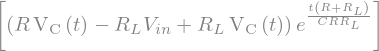

In [20]:
e5 = solve(e4, c1); e5

Therefore it seems the constant of integration at time t=0 can simply be set to $ -R_L V_{in} $ where $ V_{in} $ is simply the pulse height at every stage of evaluation and that only ever takes on one of two values.

In [21]:
e6 = e5[0].subs([(v(t), vc), (t,0)]); e6

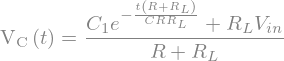

In [22]:
e4

In [23]:
fe5 = lambdify([vin, vc, rl, R, C], e6.subs([(v(t), vc), (t,0)]))

-10000


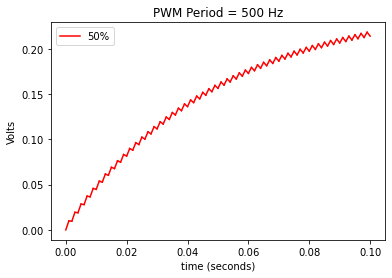

In [24]:
fig, ax = plt.subplots()

rval = 10000
cval = 1e-5
rlval = 10000

pulse_height = 1

def f(t, c1):
    return f1(t, vin, vc)

duty_cycles = [(0.5, 'r'),]

c1val = fe5(pulse_height, 0, rlval, rval, cval)
print (c1val)


period = 0.002
for duty, lblcolour in duty_cycles:
    c=-pulse_height
    for h in range(0,50):
        x = np.linspace(0,duty*period, int(duty*500) )
        y = fvc(x, c1val, rval, cval, rlval, pulse_height)
        yn = y[len(y)-1]
        #print (c1val, x[0], y[0], yn)
        c1val = fe5(0, yn, rlval, rval, cval)
        x = x +h*period
        ax.plot(x,y, color=lblcolour)
        x = np.linspace(0,(1-duty)*period, int((1-duty)*500) )
        y = fvc(x, c1val, rval, cval, rlval, 0)
        yn = y[len(y)-1]
        c1val = fe5(pulse_height, yn, rlval, rval, cval)
        x = x+duty*period+h*period   
        #print (c1val, x[0], y[0], yn)
        line, = ax.plot(x,y, color=lblcolour)
        if h==0:
            line.set_label('{}%'.format(int(duty*100)))
        
    

ax.set_title('PWM Period = {} Hz'.format(int(1/period)))
ax.set_ylabel('Volts')
ax.set_xlabel('time (seconds)')
ax.legend()


Therefore the resistance R and $ R_L $ act as a voltage divider on the PWM output